# Allison Ray's Analysis
An Exploratory Review of the Global Longitudinal University Enrollment Dataset

# Section 1: Load & Clean GLUED Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
glued_df = pd.read_csv('data/enrollments.csv')

/var/folders/8n/p5nwckxs3zj6f70jcf8c9qgw0000gn/T/ipykernel_34316/2065547143.py:1: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  glued_df = pd.read_csv('data/enrollments.csv')


Received a warning above indicating that columns 12 & 13 have mixed datatypes. Inspecting columns to decide how to handle this and which columns, if any, can be dropped.

In [3]:
glued_df.dtypes

country                    object
countrycode                object
region                     object
incomegroup                object
iau_id                     object
iau_id1                    object
eng_name                   object
orig_name                  object
foundedyr                 float64
yrclosed                  float64
private01                 float64
coordinates                object
latitude                   object
longitude                  object
phd_granting              float64
m_granting                float64
b_granting                float64
divisions                 float64
total_fields              float64
unique_fields             float64
specialized               float64
merger                    float64
noiau                     float64
year                      float64
students5_interpolated    float64
students5_extrapolated    float64
students5_estimated       float64
dtype: object

In [4]:
#checking the columns that gave the warning specifically
glued_df.iloc[:,[12,13]].dtypes

latitude     object
longitude    object
dtype: object

In [5]:
#initial check for null values
glued_df.isna().sum()

country                        0
countrycode                 1862
region                      1862
incomegroup                 1869
iau_id                         7
iau_id1                        7
eng_name                       7
orig_name                  23114
foundedyr                     35
yrclosed                  161100
private01                     35
coordinates                23208
latitude                   23208
longitude                  23208
phd_granting                  35
m_granting                140352
b_granting                140352
divisions                 140352
total_fields              140352
unique_fields             140352
specialized                   35
merger                        35
noiau                         35
year                          35
students5_interpolated    107614
students5_extrapolated     55987
students5_estimated        18741
dtype: int64

Given the missing data in students5_interpolated and students5_extrapolated, along with the instructions from the prompt to assume that students5_estimated gives us estimated enrollment, I am going to drop the the interpolated & extrapolated columns. I am also going to drop coordinates, latitude, and longitude, in light of the warning above and the scope of this investigation.

In [6]:
glued_df = glued_df.drop(columns=['coordinates', 'latitude', 'longitude', 'students5_interpolated', 'students5_extrapolated'])

Countrycode, region, and students5_estimated will likely all be used in the course of this analysis. I will begin by handling missing values in these columns. 

Since the country column is never null, we can identify which countries are missing a countrycode. Given that the number of missing values in countrycode is the same as the number of missing values in region, I hypothesize that these values are missing for the same set of countries. We can check both below.

In [7]:
# Gives us the list of countries for which a countrycode is missing
glued_df[glued_df['countrycode'].isna()]['country'].unique()

array(['taiwan', 'holy see', 'france - new caledonia', 'france - reunion',
       'france - martinique', 'france - french guyana', 'cura��ao'],
      dtype=object)

In [8]:
# Tells us whether the countries missing regions are the same as countries missing a countrycode
glued_df[glued_df['countrycode'].isna()]['country'].unique().tolist() == glued_df[glued_df['region'].isna()]['country'].unique().tolist()

True

Since there were only 7 countries missing countrycodes/regions, I looked these values up online and created mappings for both. (NB -- cura��ao is undoubtedly Curaçao, but the character issues here don't hinder interpretability so I didn't attempt to resolve.)

In [9]:
missing_country_codes = {
    'taiwan': 'TWN',
    'holy see': 'VAT', 
    'france - new caledonia': 'NCL',
    'france - reunion': 'REU',
    'france - martinique': 'MTQ',
    'france - french guyana': 'GUF',
    'cura��ao': 'CUW'
}

In [10]:
missing_regions = {
    'taiwan': 'East Asia and Pacific',
    'holy see': 'Europe and Central Asia', 
    'france - new caledonia': 'East Asia and Pacific',
    'france - reunion': 'Sub-Saharan Africa',
    'france - martinique': 'Latin America and Caribbean',
    'france - french guyana': 'Latin America and Caribbean',
    'cura��ao': 'Latin America and Caribbean'
}

In [11]:
def map_missing_country_info(df, mapping, field):
    """Fill NA columns in given field with mapping value found for country in mapping"""
    rows_to_fill = df[field].isna()
    df.loc[rows_to_fill, field] = df.loc[rows_to_fill, 'country'].map(mapping)

In [12]:
map_missing_country_info(glued_df, missing_country_codes, 'countrycode')
map_missing_country_info(glued_df, missing_regions, 'region')

After filling the region & the countrycode for each country, I want to double check that we now have a 1:1 mapping for each country and each countrycode

In [13]:
glued_df['countrycode'].nunique() == glued_df['country'].nunique()

False

The count of countrycodes and count of countries doesn't match, so we should investigate why. It could be that one code maps to multiple countries or that one country maps to multiple codes.

In [14]:
country_mappings = glued_df.groupby('countrycode')['country'].nunique().reset_index()
country_mappings[country_mappings['country'] > 1]

,countrycode,country
6,ARG,2
85,ITA,2
136,PER,2
147,ROU,2


Above we see that there are 4 codes that have 2 countries each associated with them. We should investigate why.

In [15]:
incorrect_mappings = country_mappings[country_mappings['country'] > 1]
incorrect_codes = incorrect_mappings['countrycode'].to_list()
glued_df[glued_df['countrycode'].isin(incorrect_codes)]['country'].unique()

array(['argentina"', 'italy"', 'peru"', 'romania"', 'romania', 'italy',
       'peru', 'argentina'], dtype=object)

Above we can see that some of the country text strings have erroneous trailing double quotes. We can remove these to fix our mappings and double check that the number of unique countries now matches the number of unique countrycodes.

In [16]:
glued_df['country'] = glued_df['country'].str.replace('"', '')
glued_df['country'].nunique() == glued_df['countrycode'].nunique()

True

In [17]:
glued_df.isna().sum()

country                     0
countrycode                 0
region                      0
incomegroup              1869
iau_id                      7
iau_id1                     7
eng_name                    7
orig_name               23114
foundedyr                  35
yrclosed               161100
private01                  35
phd_granting               35
m_granting             140352
b_granting             140352
divisions              140352
total_fields           140352
unique_fields          140352
specialized                35
merger                     35
noiau                      35
year                       35
students5_estimated     18741
dtype: int64

There are 35 rows where the year is NaN (which I suspect correspond to the 35 null values in the other columns listed above). Reviewing these below, we see that this is the case.

In [18]:
glued_df[glued_df['year'].isna()]

,country,countrycode,region,incomegroup,iau_id,iau_id1,eng_name,orig_name,foundedyr,yrclosed,...,m_granting,b_granting,divisions,total_fields,unique_fields,specialized,merger,noiau,year,students5_estimated
0,argentina,ARG,Latin America and Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,italy,ITA,Europe and Central Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,peru,PER,Latin America and Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,peru,PER,Latin America and Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,romania,ROU,Europe and Central Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,romania,ROU,Europe and Central Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,romania,ROU,Europe and Central Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111040,peru,PER,Latin America and Caribbean,Upper middle income,IAU-017603,IAU-017603-2,"University \""San Martin De Porres\""\t""\t1969.0...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111041,peru,PER,Latin America and Caribbean,Upper middle income,IAU-017603,IAU-017603-2,"University \""San Martin De Porres\""\t""\t1969.0...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111042,peru,PER,Latin America and Caribbean,Upper middle income,IAU-017603,IAU-017603-2,"University \""San Martin De Porres\""\t""\t1969.0...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Given that this is a relatively small proportion of our overall data, and given that these rows have neither iau_id/iau_id1 value nor enrollment information, I will drop these rows.

In [19]:
glued_df = glued_df.dropna(subset=['year'])

The next column with a significant number of nulls that will be used heavily in our analysis is students5_estimated.

In [20]:
glued_df.isna().sum()

country                     0
countrycode                 0
region                      0
incomegroup              1862
iau_id                      0
iau_id1                     0
eng_name                    0
orig_name               23079
foundedyr                   0
yrclosed               161065
private01                   0
phd_granting                0
m_granting             140317
b_granting             140317
divisions              140317
total_fields           140317
unique_fields          140317
specialized                 0
merger                      0
noiau                       0
year                        0
students5_estimated     18706
dtype: int64

I would like to start conservatively by removing schools for which we have no enrollment data. Without any institution-specific eneollment information, if would be difficult to estimate or interpolate enrollment at these institutions. Below we see that there are 878 unique schools which have no values in students5_estimated.

In [21]:
nulls_by_school = glued_df.groupby('iau_id1').agg(
    listed_years = ('students5_estimated', 'count')
).reset_index()
schools_with_no_enrollment_data = nulls_by_school[nulls_by_school['listed_years'] == 0]['iau_id1'].to_list()
len(schools_with_no_enrollment_data)

878

In [22]:
#Removing rows identified as schools that have no enrollment data for any year.
glued_df = glued_df[~(glued_df['iau_id1'].isin(schools_with_no_enrollment_data))]

In [23]:
glued_df.isna().sum()

country                     0
countrycode                 0
region                      0
incomegroup               917
iau_id                      0
iau_id1                     0
eng_name                    0
orig_name               17088
foundedyr                   0
yrclosed               150332
private01                   0
phd_granting                0
m_granting             130113
b_granting             130113
divisions              130113
total_fields           130113
unique_fields          130113
specialized                 0
merger                      0
noiau                       0
year                        0
students5_estimated      7966
dtype: int64

After dropping schools with no available enrollment data, we have reduced null enrollments by about 10k; however, around 8k persist. Given more time, I might attempt to categorize these into 1) nulls where earlier data is available, 2) nulls where later data is available, or 3) nulls where both earlier and later data is available. With that, I might be able to estimate enrollment for those missing years at these institutions. Given the time constraint on this exercise, however, (as well as the fact that this is meant to be exploratory, rather than to make specific predictions), I am going to drop the remaining null rows. This will have the negative impact of causing this to undercount the number of institutions as well as potentially undercounting enrollment in years where enrollment estimates would have been better served by extrapolation/interpolation. 

In [24]:
glued_df = glued_df.dropna(subset=['students5_estimated'])

In [25]:
glued_df.isna().sum()

country                     0
countrycode                 0
region                      0
incomegroup               588
iau_id                      0
iau_id1                     0
eng_name                    0
orig_name               15079
foundedyr                   0
yrclosed               142407
private01                   0
phd_granting                0
m_granting             122292
b_granting             122292
divisions              122292
total_fields           122292
unique_fields          122292
specialized                 0
merger                      0
noiau                       0
year                        0
students5_estimated         0
dtype: int64

As a final check before beginning exploration, I would like to check if there are duplicated records. For the purpose of this exercise, I would consider a rows duplicates if they have the same iau_id1 and the same year.

In [26]:
#check the number of rows that have identical id AND year
len(glued_df[glued_df.duplicated(subset=['iau_id1', 'year'])])

0

The filter above shows us that there are no rows with duplicated id/year combinations.

# Section 2: Exploratory Analysis

I'd like to begin with an understanding of general trends in terms of enrollment. Visualizing all countries at once would be overwhelming, but looking solely at a global trendline might obfuscate regional trends. Thus, I will start by analyzing raw estimated enrollment numbers per region.

In [27]:
regional_enrollment_raw = glued_df.groupby(['region', 'year']).agg(
    enrollment = ('students5_estimated', 'sum')
).reset_index()

In [28]:
#defining helper function to reset column types
def set_type(df, column, goaltype):
    df[column] = df[column].astype(goaltype)

In [29]:
#Setting year and enrollment as an int; could also use pd datetime for year, but this would be unnecessarily complex.
set_type(regional_enrollment_raw, 'year', int)
set_type(regional_enrollment_raw, 'enrollment', int)
regional_enrollment_raw

,region,year,enrollment
0,East Asia and Pacific,1950,1033729
1,East Asia and Pacific,1955,1468943
2,East Asia and Pacific,1960,2479525
3,East Asia and Pacific,1965,3460982
4,East Asia and Pacific,1970,4766099
...,...,...,...
100,Sub-Saharan Africa,2000,2254304
101,Sub-Saharan Africa,2005,3394615
102,Sub-Saharan Africa,2010,5186427
103,Sub-Saharan Africa,2015,7202555


Text(0, 0.5, 'Students Enrolled (in millions)')

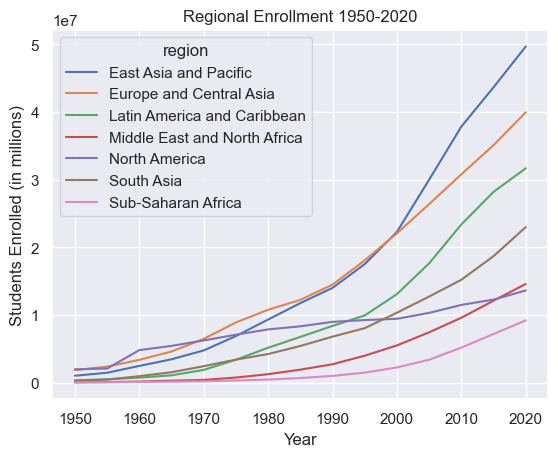

In [30]:
sns.set_theme()
sns.lineplot(data=regional_enrollment_raw, x='year', y='enrollment', hue='region')

plt.title("Regional Enrollment 1950-2020")
plt.xlabel("Year")
plt.ylabel("Students Enrolled (in millions)")

Here, we see that enrollment at each 5 year interval for each region increases monotonically. However, at a glance, there appear to be two major patterns of growth. While the North American regions sees an abrupt increase between 1955 and 1950, thereafter, it appears to grow more or less linearly. By contrast, all other regions appear to follow more exponential growth patterns (though they are at different points in their curves). 

At this point, I would like to call out the limitations of the visualization above. 
1. First and foremost, this dataset does not include population. The enrollment growth we see in all regions could be attributable to population growth in each region. Further analysis should incorporate national population figures to control for this.
2. Secondly, these regional trends (as well as the implied global trend) will be dominated by the most populous countries within each region. For instance, the small jump in North American enrollment between 1955 and 1960 is likely largely attributable to the USA. A composite value of average growth per country per region, rather than raw growth over the entire population, could control for this.

I hypothesize that the visible jump in enrollment in North America is indicative of a large jump in USA enrollment, given that the USA makes up a significant portion of the North American population. To identify years of very high growth, I will calculate 5-year change, mean 5-year change, and standard deviation for same per country. I will then calculate the z-score for the change each 5-year period and identify years of anomalous growth.

In [31]:
enrollment_by_country = glued_df.groupby(['countrycode', 'year']).agg(
    total_students_enrolled = ('students5_estimated', 'sum'),
    total_institutions = ('iau_id1', 'nunique')
).reset_index()
enrollment_by_country['enrollment_change'] = enrollment_by_country.groupby('countrycode')['total_students_enrolled'].pct_change() * 100

In [32]:
#calculate mean & std per country
change_stats_per_country = enrollment_by_country.groupby('countrycode').agg(
    mean_change = ('enrollment_change', 'mean'),
    enrollment_change_std = ('enrollment_change', 'std')
).reset_index()

In [33]:
#merge this back
enrollment_by_country = enrollment_by_country.merge(change_stats_per_country, on='countrycode')

In [34]:
#calculate z score
enrollment_by_country['z_score'] = (enrollment_by_country['enrollment_change'] - enrollment_by_country['mean_change']) / enrollment_by_country['enrollment_change_std']

Having added this additional statistical data, I would now like to review USA growth patterns for each 5 year period.

In [35]:
#Review USA Patterns
enrollment_by_country[enrollment_by_country['countrycode'] == 'USA']

,countrycode,year,total_students_enrolled,total_institutions,enrollment_change,mean_change,enrollment_change_std,z_score
2395,USA,1950.0,1888236.0,472,NaN,16.608419,34.754083,NaN
2396,USA,1955.0,1965641.0,481,4.099329,16.608419,34.754083,-0.359932
2397,USA,1960.0,4653250.0,1062,136.729393,16.608419,34.754083,3.456313
2398,USA,1965.0,5159693.0,1148,10.883640,16.608419,34.754083,-0.164722
2399,USA,1970.0,5741745.0,1243,11.280749,16.608419,34.754083,-0.153296
2400,USA,1975.0,6358447.0,1349,10.740672,16.608419,34.754083,-0.168836
2401,USA,1980.0,6968148.0,1381,9.588835,16.608419,34.754083,-0.201979
2402,USA,1985.0,7210475.0,1396,3.477639,16.608419,34.754083,-0.377820
2403,USA,1990.0,7673296.0,1418,6.418731,16.608419,34.754083,-0.293194
2404,USA,1995.0,7806999.0,1436,1.742445,16.608419,34.754083,-0.427748


Above, we see that the growth from 1955 to 1960 has a z-score of 3.46. Using either a one- or two-tailed p-value test, this year-over-year change is undoubtedly significant. We may correlate this growth with the growth in the total number of institutions, which also more than doubled during this time period. It's possible that the extreme growth seen here may be attributable to missing data prior to 1960; however, this likely also to some extent reflects real growth in US university enrollment.

We may expand the application of this analysis to identify years of anomalous growth in other countries. In order to ignore anomalies due to small sample sizes, I will ignore countries/years with fewer than 500,000 total students enrolled.

In [36]:
enrollment_by_country[enrollment_by_country['total_students_enrolled'] >= 500000].sort_values('z_score', ascending=False).head(10)

,countrycode,year,total_students_enrolled,total_institutions,enrollment_change,mean_change,enrollment_change_std,z_score
1505,MMR,1975.0,667721.0,26,1845.347279,153.433312,488.560200,3.463061
2397,USA,1960.0,4653250.0,1062,136.729393,16.608419,34.754083,3.456313
1933,RUS,1960.0,596701.0,383,321.661061,45.076699,81.473743,3.394767
781,GBR,1955.0,522741.0,176,69.099608,23.630289,15.116800,3.007867
1004,IND,1960.0,856661.0,116,135.554156,40.231723,32.356605,2.945996
568,DEU,1975.0,798737.0,224,60.396042,21.200390,13.921612,2.815454
362,CAN,1970.0,505402.0,117,82.375272,27.358691,22.872297,2.405381
744,FRA,1970.0,611330.0,264,77.806798,28.157061,21.011929,2.362931
1058,IRQ,2015.0,780745.0,90,71.705520,37.955663,15.972339,2.113019
2334,TWN,2005.0,516552.0,63,135.391262,52.254018,43.856441,1.895668


Reviewing the top 3 results above, we see that data available for Myanmar shows extreme growth (over 10-fold) from 1970 to 1975. However, the domestic turmoil of the period (a new constitution established one-party rule) makes it difficult to hypothesize whether this growth is genuine or the result of reporting anomalies during the time period.

Significant growth in Russian university enrollment during the same time period that US enrollment spikes (1955-1960) is also noted. This could point to the rising technological competition of the Cold War, with this time frame corresponding to the early years of the Space Race. Additionally, the passage of the G.I. Bill in the US in 1944 could have contributed to increased access to higher education in the US. This combination of domestic policy and international politics may have contributed to the sharp rise in US enrollment. We may map US enrollment and Russian enrollment against each other to see more.

In [37]:
#Filter to US & Russia
us_and_russia = enrollment_by_country[enrollment_by_country['countrycode'].isin(['USA','RUS'])]

Text(0, 0.5, 'Percent Change from 5 years prior')

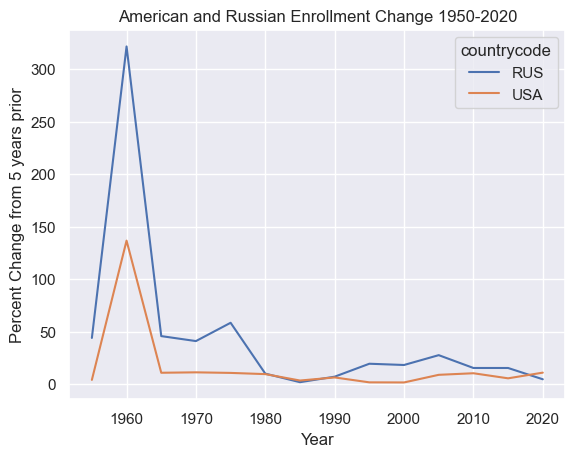

In [38]:
#Plot US & Russian Enrollment Change as Pct against each other
sns.set_theme()
sns.lineplot(data=us_and_russia, x='year', y='enrollment_change', hue='countrycode')

plt.title("American and Russian Enrollment Change 1950-2020")
plt.xlabel("Year")
plt.ylabel("Percent Change from 5 years prior")

Indeed, we see that the trendlines in percent change per five year period for Russia and the US bear a visible similarity to one another. Though missing data for both countries could be a contributing factor to the size of the spikes we see from 1955-1960, we may hypothesize that the drive for technological supremacy during the Cold War (and specifically during the Space Race era) led to a significant uptick in enrollment for both countries.

# Section 3: Evaluation of Correlation between GDP and Enrollment

First we must load and inspect our GDP data.

In [39]:
gdp_df = pd.read_csv('data/Countries GDP 1960-2020.csv')

Off the bat, the name of this file indicates that it only represents the years 1960-2020, so we must expect that we will be missing some data by year.

In [40]:
gdp_df.columns

Index(['Country Name', 'Country Code', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020'],
      dtype='object')

Indeed, we see that this data only contains years 1960-2020 (and contains them in 1-year increments, as opposed to 5 year increments). We also see that this data is arranged horizontally per country; in order to join this data with the enrollment data we will need to reformat it.

In [41]:
gdp_df = gdp_df.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='GDP')
gdp_df

,Country Name,Country Code,Year,GDP
0,Africa Eastern and Southern,AFE,1960,1.931311e+10
1,Africa Western and Central,AFW,1960,1.040428e+10
2,Australia,AUS,1960,1.860679e+10
3,Austria,AUT,1960,6.592694e+09
4,Burundi,BDI,1960,1.960000e+08
...,...,...,...,...
7315,St. Vincent and the Grenadines,VCT,2020,8.074741e+08
7316,World,WLD,2020,8.470000e+13
7317,South Africa,ZAF,2020,3.350000e+11
7318,Zambia,ZMB,2020,1.811063e+10


In [42]:
# We could also convert 'Year' to a pd datetime format and then accessing the year attribute, but this would be more complex than is necessary.
set_type(gdp_df, 'Year', int)
#Drop rows with years that aren't divisible by 5; won't be necessary for join with enrollment data.
gdp_df = gdp_df[gdp_df['Year'] % 5 == 0]

We know we will have missing years from this data; we should also check the number of countries represented in the data.

In [43]:
gdp_df['Country Code'].nunique()

120

Above, we see that we only have GDP data for 120 countries. This should be adequate to investigate if a relationship exists between GDP and enrollment, but any conclusions will naturally only apply to countries for which we had data.

In [44]:
#Convert country codes to uppercase to ensure they match enrollment codes for merge
gdp_df.loc[:,'Country Code'] = gdp_df['Country Code'].str.upper()

Next, we can merge the gdp data with the enrollment data. Rather than merging this with the original GLUED DataSet and re-aggregating, I will merge this with the DataFrame that is already aggregated by country.

In [45]:
combined_df = enrollment_by_country.merge(gdp_df, left_on=['countrycode', 'year'], right_on=['Country Code', 'Year'], how='left')

In [46]:
#Drop redundant Country Name & Year columns from GDP; keep from enrollments
combined_df = combined_df.drop(columns=['Country Name', 'Year'])

In [47]:
combined_df.columns

Index(['countrycode', 'year', 'total_students_enrolled', 'total_institutions',
       'enrollment_change', 'mean_change', 'enrollment_change_std', 'z_score',
       'Country Code', 'GDP'],
      dtype='object')

In [48]:
#Check number of Country Codes from GDP data
combined_df['Country Code'].nunique()

86

Above, we see that only 86 matches were found between country codes in the GDP data vs country codes in the enrollment data. We should inspect the differences between the sets.

In [49]:
# Number of country codes which appeared in GDP data but not in merged data
len(set(gdp_df['Country Code']) - set(combined_df['Country Code']))

34

In [50]:
# Number of country codes which appeared in enrollment data but not in merged data
len(set(enrollment_by_country['countrycode']) - set(combined_df['Country Code']))

107

Inspection of first set shows codes that exist in the GDP data but not in the enrollment data; upon review, many of these seem to represent geographic or demographic aggregates (e.g. AFE for Africa Eastern & Southern, HIC for High Income Countries, etc).

The second list shows us countries for which we have enrollment data and have no GDP data. These represent real countries which simply are not represented in the GDP data.

Though countries will be omitted from this analysis, we can still investigate a correlation between GDP and enrollment. First, we can check the correlation betwen GDP and raw enrollment.

Text(0, 0.5, 'National Enrollment (in millions)')

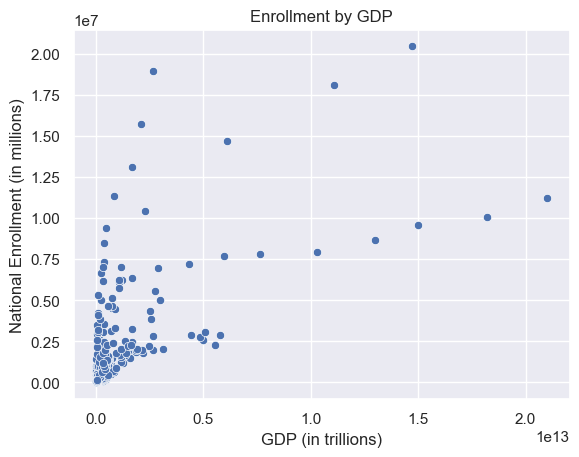

In [51]:
sns.scatterplot(data=combined_df, x='GDP', y='total_students_enrolled')

plt.title("Enrollment by GDP")
plt.xlabel('GDP (in trillions)')
plt.ylabel('National Enrollment (in millions)')

In [52]:
#Check correlation of raw gdp to raw enrollment
float(combined_df['total_students_enrolled'].corr(combined_df['GDP']))

0.6781554921974869

There appears to be a moderate correlation between GDP (in any country in any given year) and total enrollment (in that same country in that same year). There could be a number of factors that contribute to this, however. As above, a higher population may correlate with both higher enrollment and higher GDP.

We may also investigate if there is a correlation between GDP growth and enrollment growth.

In [53]:
#Calculate pct change in gdp
combined_df['gdp_pct_change'] = combined_df.groupby('countrycode')['GDP'].pct_change(fill_method=None) * 100

We can now directly compare change in gdp to change in enrollment.

Text(0, 0.5, '5-Year Percent Change in National Enrollment')

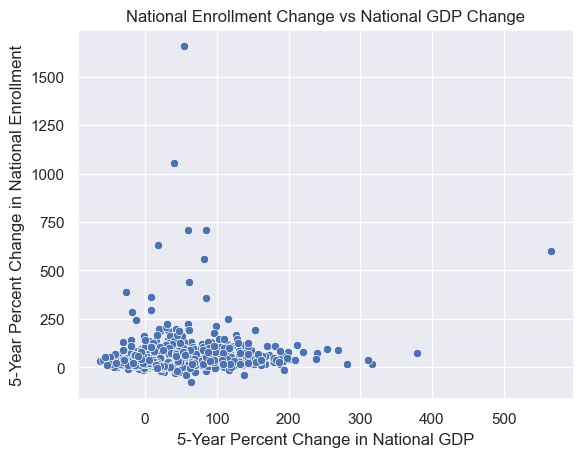

In [54]:
sns.scatterplot(data=combined_df, x='gdp_pct_change', y='enrollment_change')

plt.title("National Enrollment Change vs National GDP Change")
plt.xlabel('5-Year Percent Change in National GDP')
plt.ylabel('5-Year Percent Change in National Enrollment')

In [55]:
#Get correlation between GDP change and enrollment change
float(combined_df['enrollment_change'].corr(combined_df['gdp_pct_change']))

0.10518910520713082

Above, we see a negligible positive correlation between GDP and enrollment change. This suggests that while a country's GDP is correlated to its total enrollment, a rise in GDP for a specific country might not correspond to a rise in enrollment in the same country.

# Summary
Analysis of the Global Longitudinal University Enrollment Dataset shows several notable trends:
1. Enrollment increased monontonically both regionally and globally during the observed time period (1950-2020)
2. Both Russia and the US experienced abnormally high rate of growth in enrollment between 1955 and 1960, corresponding to the Cold War Era.
3. A moderate correlation is noted between GDP and national enrollment in any given year.
4. None of these analyses account for population, which is likely a significant factor in some of the trends observed here.

Possibilities for further investigation:
1. Include population data in analysis of both enrollment and GDP
2. Methodically fill missing enrollment data, rather than dropping
3. Investigate abnormal drops in enrollment, rather than focusing solely on abnormal growth.

A Note on Methodology:
This analysis followed an exploratory path with observations derived from anomalies. For a more rigorous testing application, hypotheses should ideally be made before beginning investigation. 